# eTransafe valsartan Heatmap

This is the use scenario that has been described in the eTox project for exploring the differences with respect to adverse events between omeprazole preclinical and clinical. In order to compute these results the following scenario is executed:
1. Translate the provided compound (e.g., omeprazole) to a SMILES
2. Retrieve data from the preclinical and clinical databases
3. Aggregate the data per system organ class
4. Visualize the data using a heatmap

(C) 2021 Erasmus University Medical Center, Rotterdam, The Netherlands
Author: Erik M. van Mulligen, e.vanmulligen@erasmusmc.nl

In [2]:
from knowledgehub.api import KnowledgeHubAPI
import ipywidgets as w
from IPython.display import display, Javascript, clear_output
from ipypublish import nb_setup
import numpy as np
import numpy.ma as ma
import seaborn as sns
import pandas
import matplotlib.pyplot as plt

In [7]:
api = KnowledgeHubAPI(server='DEV', client_secret='39c644b3-1f23-4d94-a71f-e0fb43ebd760')

## 1. Authenticate with the KnowledgeHub
Get authenticated to get access to the KnowledgeHub

In [8]:
username = w.Text(
    value='erik.mulligen',
    placeholder='Knowledge Hub account',
    description='username:',
    disabled=False
)

password = w.Password(
    value='',
    placeholder='Knowledge Hub password',
    description='password:',
    disabled=False
)

display(username)
display(password)

Text(value='erik.mulligen', description='username:', placeholder='Knowledge Hub account')

Password(description='password:', placeholder='Knowledge Hub password')

In [9]:
print(("not " if not api.login(username.value, password.value) else "") + "successfully logged in")

401
not successfully logged in


## 2. Translate compound to SMILES using semantic services
For the entered compound name, retrieve the associated SMILES using the semantic services

In [5]:
compoundName = w.Text(value='valsartan',placeholder='compound name', description='compound:', disabled=False)
compoundBtn = w.Button(description='Retrieve')
compoundSmile = None

def on_compound_entered(_):
        compound = api.SemanticService().normalize(compoundName.value, ['RxNorm','smiles'])
        if 'concepts' in compound:
            for concept in compound['concepts']:
                if 'vocabularyId' in concept:
                    if concept['vocabularyId'] == 'smiles':
                        global compoundSmile
                        compoundSmile = concept['conceptCode']
                        clear_output(wait=True)
                        print(f'Found SMILES {compoundSmile} for {compoundName.value}')
                        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

compoundBtn.on_click(on_compound_entered) 
w.VBox([compoundName, compoundBtn])

Found SMILES CCCCC(=O)N(Cc1ccc(cc1)c2ccccc2c3nnn[nH]3)[C@@H](C(C)C)C(=O)O for valsartan


<IPython.core.display.Javascript object>

In [7]:
compoundIds = []
compoundNames = []
concept = api.SemanticService().normalize(compoundName.value, ['RxNorm'])
if 'concepts' in concept and len(concept['concepts']) == 1:
    compoundIds.append(concept['concepts'][0]['conceptCode'])
    compoundNames.append(concept['concepts'][0]['conceptName'])


## 3. Retrieve data from the preclinical and clinical databases

In [8]:

studies = {
    'Medline': api.Medline().getStudiesByCompoundIds(compoundIds),
    'FAERS': api.Faers().getStudiesByCompoundIds(compoundIds),
    'ClinicalTrials': api.ClinicalTrials().getStudiesByCompoundIds(compoundIds),
    'eTOXSys': api.eToxSys().getStudiesByCompoundNames(compoundNames)
}

count = 0
for source in studies:
    count += len(studies[source])
    print(f'Found {len(studies[source])} studies.')

[1275]
Found 30 studies.
Found 707 studies.
Found 5564 studies.
Found 18925 studies.


## 4. Aggregate the data per system organ class

Since the eTox data reports events with an organ. We use our own method to map it to MedDRA's system organ class to make it comparable

In [9]:
system = {}
socs = {}
socs_labels = []

# retrieve all system organ classes used
for source in studies:
    for study in studies[source]:
        if study['FINDING']['finding'] != None and study['FINDING']['finding'] != 'No abnormalities detected' and len(study['FINDING']['finding']) > 0:
            specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
            for specimenOrgan in specimenOrgans:
                if len(specimenOrgan) > 0:
                    if specimenOrgan not in socs:
                        socs[specimenOrgan] = 0
                        socs_labels.append(specimenOrgan)

# travers the studies and count distinct findings per system organ class

findings_rows_cols = [[[] for study in studies] for soc in socs_labels]

for source in studies:
    # initialize for each source again a data structure to capture per combination of a system organ class 
    # and a compound what findings have been found
    
    col = list(studies.keys()).index(source)

    for study in studies[source]:
        if study['FINDING']['finding'] != None and study['FINDING']['finding'] != 'No abnormalities detected' and len(study['FINDING']['finding']) > 0:
            specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
            for specimenOrgan in specimenOrgans:
                if len(specimenOrgan) > 0:
                    compound = study['COMPOUND']['name'].lower()
                    row = socs_labels.index(specimenOrgan)
                    finding = study['FINDING']['finding']
                    if finding not in findings_rows_cols[row][col]:
                        socs[specimenOrgan] += 1
                        findings_rows_cols[row][col].append(finding)
          
# sort the socs per count
all_socs = {k: v for k, v in sorted(socs.items(), key=lambda item: item[1], reverse=True)}

# traverse all studies and create a matrix per source
findings_rows_cols = [[[] for study in studies] for soc in socs_labels]

matrix = {
    'data':np.zeros((len(all_socs),len(studies)), dtype=int).tolist(), 
    'rows':list(all_socs.keys()), 
    'cols':list(studies.keys())
}

# initialize for each source again a data structure to capture per combination of a system organ class 
# and a compound what findings have been found
        
for source in studies:
    for study in studies[source]:
        if study['FINDING']['finding'] != None and study['FINDING']['finding'] != 'No abnormalities detected' and len(study['FINDING']['finding']) > 0:
            specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
            for specimenOrgan in specimenOrgans:
                if len(specimenOrgan) > 0:
                    row = matrix['rows'].index(specimenOrgan)
                    col = matrix['cols'].index(source)
                    finding = study['FINDING']['finding']
                    if finding not in findings_rows_cols[row][col]:
                        matrix['data'][row][col] += 1
                        findings_rows_cols[row][col].append(finding)             

## 5. Visualize the data using a heatmap

Using seaborn to visualize the content of the various databases. Note that we have to think about ways to easier compare the various results.

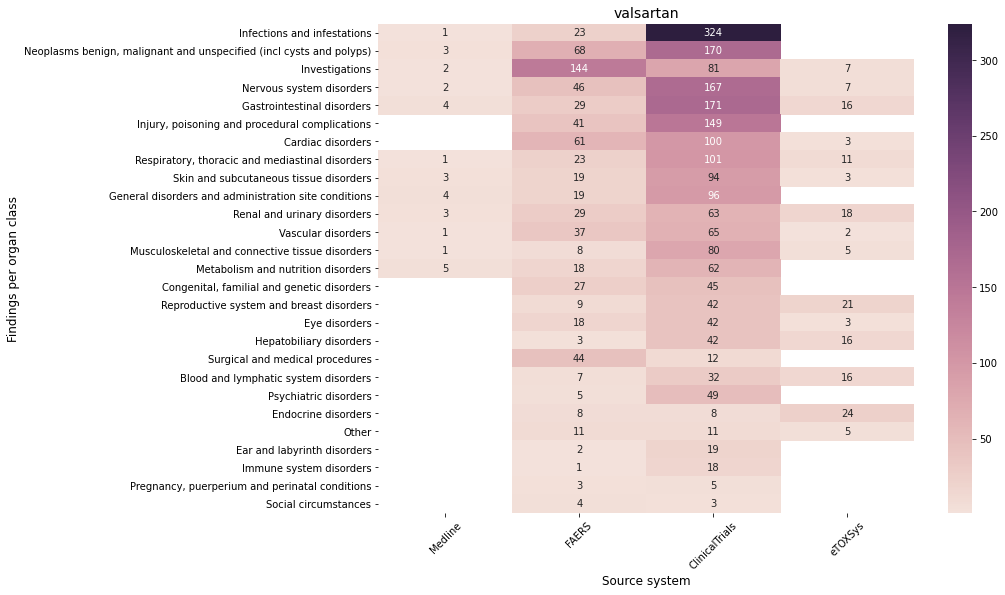

In [10]:
plt.figure(figsize=(12,9))
    
# create mask
data_mask = ma.array(np.zeros((len(matrix['rows']), len(matrix['cols']))))
for r in range(0, len(matrix['rows'])):
    for c in range(0, len(matrix['cols'])):
        data_mask[r][c] = 1 if matrix['data'][r][c] == 0 else 0

colormap = sns.cubehelix_palette(as_cmap=True, light=.9)
ax = sns.heatmap(matrix['data'], mask=data_mask, xticklabels=matrix['cols'], yticklabels=matrix['rows'], annot=True, fmt=".0f", cmap=colormap) 
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45)
plt.title(compoundName.value, fontsize = 14)
plt.ylabel("Findings per organ class", fontsize = 12)
plt.xlabel("Source system", fontsize = 12)
plt.show()